In [392]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
import math


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/btcinusd/BTC-2019min.csv
/kaggle/input/btcinusd/BTC-Hourly.csv
/kaggle/input/btcinusd/BTC-Daily.csv
/kaggle/input/btcinusd/BTC-2020min.csv
/kaggle/input/btcinusd/BTC-2017min.csv
/kaggle/input/btcinusd/BTC-2018min.csv
/kaggle/input/btcinusd/BTC-2021min.csv


# **Preprosessing**

In [393]:
df = pd.read_csv('/kaggle/input/btcinusd/BTC-Daily.csv')
# Removing all unessesary columns ( See Research )
df = df = df.drop(["Volume BTC", "unix","Volume USD", "symbol","open"], axis=1)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df.index = df.pop("date")
df

,high,low,close
date,,,
2014-11-28,381.34,360.57,376.28
2014-11-29,386.60,372.25,376.72
2014-11-30,381.99,373.32,373.34
2014-12-01,382.31,373.03,378.39
2014-12-02,382.86,375.23,379.25
...,...,...,...
2022-02-25,39727.97,38027.61,39231.64
2022-02-26,40330.99,38600.00,39146.66
2022-02-27,39886.92,37015.74,37712.68


# **Standardization**

In [394]:
# Scaler for N-Dimensional Array
df_features = df.drop(['close'],axis=1)
df_np = df_features.to_numpy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_np, (-1,1))
df_scaled[0]

array([0.00244959, 0.00314943])

In [395]:
# Scaler for 1D array
df_close = pd.DataFrame(df['close'])
df_close_np = df_close.to_numpy()
to_inverse_scale = MinMaxScaler()
df_close_scale = to_inverse_scale.fit_transform(df_close_np)
df_close_scale

array([[0.00317937],
       [0.0031859 ],
       [0.00313575],
       ...,
       [0.55715655],
       [0.63826253],
       [0.63835898]])

# **Converting Data to 3 Dimensions **

In [396]:
x = [] # The features needed for prediction.
y = [] # The expected result.

for i in range(len(df_scaled)-6):
    x.append(df_scaled[i:i+6])

for i in range(len(df_close_scale)-1):
        y.append(df_close_scale[i][0])


# Converting to Numpy array for easier reading by the ML-Algorithm
X = np.array(x)
Y = np.array(y)




# **Splitting the Data (Train/Test)**

In [397]:
train_no = math.floor(len(X) * 0.7) # 70% for training, 30% For Testing
total_no = len(X) 
X_Train, Y_Train = X[:train_no][:train_no], Y[:train_no]
X_Test, Y_Test = X[train_no: total_no - 1], Y[train_no: total_no - 1]

In [398]:
print(X_Train.shape, Y_Train.shape)
print(X_Test.shape, Y_Test.shape)

(1851, 6, 2) (1851,)
(793, 6, 2) (793,)


In [399]:
X_Train, Y_Train = X[:train_no], Y[:train_no]
X_Test, Y_Test = X[train_no: total_no - 1], Y[train_no: total_no - 1]

# **Developing The Model**

In [400]:
model = Sequential()
# Three layers, Final Output is in an array of 10 predictions
model.add(LSTM(30, return_sequences=True, input_shape=(6,2)))
model.add(LSTM(25, return_sequences=True))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(15))
model.add(Dense(10))
          

In [401]:
model.compile(optimizer='adam', loss='mean_squared_error') # Compling the Model

In [402]:
modeled = model.fit(X_Train, Y_Train, batch_size=1, epochs=10) # Training the model

Epoch 1/10
1851/1851 [==============================] - 12s 5ms/step - loss: 1.8043e-04
Epoch 2/10
1851/1851 [==============================] - 9s 5ms/step - loss: 3.8293e-05
Epoch 3/10
1851/1851 [==============================] - 9s 5ms/step - loss: 3.9837e-05
Epoch 4/10
1851/1851 [==============================] - 9s 5ms/step - loss: 4.6214e-05
Epoch 5/10
1851/1851 [==============================] - 9s 5ms/step - loss: 3.4445e-05
Epoch 6/10
1851/1851 [==============================] - 9s 5ms/step - loss: 2.7883e-05
Epoch 7/10
1851/1851 [==============================] - 9s 5ms/step - loss: 3.7660e-05
Epoch 8/10
1851/1851 [==============================] - 9s 5ms/step - loss: 2.8224e-05
Epoch 9/10
1851/1851 [==============================] - 9s 5ms/step - loss: 3.5472e-05
Epoch 10/10
1851/1851 [==============================] - 9s 5ms/step - loss: 2.5009e-05


# **Testing the Model**

In [403]:
predictions = model.predict(X_Test)
predictions = to_inverse_scale.inverse_transform(predictions) # Reverse the standardization.


In [410]:
# Putting the predictions in an array to convert into dataframe column later.
valid = []
for i in range(len(predictions)):
    valid.append(predictions[i][9]) # Using the final prediction in the array.
    

# **Validating the Results**

In [411]:
new_df = pd.DataFrame(df[train_no: total_no - 1])

new_df = new_df.drop(["high","low"], axis=1)

new_df['Prediction'] = valid


new_df

,close,Prediction
date,,
2019-12-23,7316.17,7757.924316
2019-12-24,7251.52,7674.064941
2019-12-25,7195.79,7659.662109
2019-12-26,7188.30,7692.538574
2019-12-27,7246.00,7680.767090
...,...,...
2022-02-18,39996.99,30019.087891
2022-02-19,40109.02,29870.632812
2022-02-20,38373.90,29671.347656


<AxesSubplot:xlabel='date'>

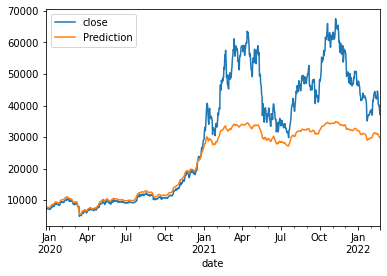

In [407]:
new_df.plot()

In [408]:
new_df.corr() # Accuracy around 99.5%

,close,Prediction
close,1.000000,0.968686
Prediction,0.968686,1.000000


In [412]:
test = X_Test[787:]

tests = model.predict(test)
tests =to_inverse_scale.inverse_transform(tests)
t = []
for i in range(len(tests)):
    t.append(tests[i][9])

t

[30333.576, 30019.088, 29870.633, 29671.348, 29529.906, 29493.03]